In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from keras.utils import to_categorical
from skimage import io, transform
import time
from sklearn.model_selection import train_test_split
seed = 333
np.random.seed(seed)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))



['raw-img']


In [2]:
img_dir="../input/raw-img" 

print(os.listdir(img_dir))

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [3]:
def load_data(img_dir):
    X = []
    y = []
    labels = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        if folder_name in ( "gatto","cane"):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
                if file_name.endswith('jpeg'):
                    im = io.imread(f'{img_dir}/{folder_name}/{file_name}')
                    if im is not None:
                        im = transform.resize(im, (100, 100))
                        X.append(im)
                        y.append(idx)
        idx+=1
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

In [4]:
X,y,labels = load_data(img_dir)


100%|██████████| 1668/1668 [00:08<00:00, 207.49it/s]


In [5]:
#fix y
y=y.reshape(-1,1)
for i,_ in enumerate(y):
    if y[i]== -1:
        y[i]=0
    else:
        y[i]=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test

train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((4872, 100, 100, 3), (4872, 1), (1218, 100, 100, 3), (1218, 1))

In [6]:
#show random samples
# rand_14 = np.random.randint(0, train_img.shape[0],14)
# sample_img = train_img[rand_14]
# sample_labels = train_labels[rand_14]
# num_rows, num_cols = 2, 7
# f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01})
# for r in range(num_rows):
#     for c in range(num_cols):
#         image_index = r * 7 + c
#         ax[r,c].axis("off")
#         ax[r,c].imshow(sample_img[image_index])
#         ax[r,c].set_title('%s' % get_sample_labels[image_index])
# plt.show()
# plt.close()

In [7]:
#one-hot-encode the labels
num_classes = len(labels)
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape


((4872, 2), (1218, 2))

In [8]:
# re-shape the images data
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((4872, 100, 100, 3), (1218, 100, 100, 3))

In [9]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels_cat.shape

((4385, 100, 100, 3),
 (4385, 2),
 (487, 100, 100, 3),
 (487, 2),
 (1218, 100, 100, 3),
 (1218, 2))

In [10]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [11]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [12]:
def get_commonname(idx):
    sciname = labels[idx][0]
    return { 'cane':'dog','gatto':'cat'}[sciname]


In [13]:
# CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import numpy as np
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import mnist
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import Image
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.25,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
# datagen = ImageDataGenerator(
#     rotation_range=8,
#     shear_range=0.3,
#     zoom_range = 0.08,
#     width_shift_range=0.08,
#     height_shift_range=0.08)
#create multiple cnn model for ensembling
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# train
epochs = 10
j=0
start_time = time.time()
history = model.fit_generator(datagen.flow(train_data2, train_labels_cat2, batch_size=64),
        epochs = epochs, steps_per_epoch = train_data2.shape[0]/64,
        validation_data = (val_data, val_labels_cat), callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
69/68 [==============================] - 10s 142ms/step - loss: 0.1044 - accuracy: 0.9576 - val_loss: 0.0014 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
69/68 [==============================] - 8s 114ms/step - loss: 1.4070e-04 - accuracy: 1.0000 - val_loss: 2.2757e-05 - val_accuracy: 1.0000 - lr: 9.5000e-04
Epoch 3/10
69/68 [==============================] - 8s 114ms/step - loss: 7.5467e-05 - accuracy: 1.0000 - val_loss: 8.0778e-09 - val_accuracy: 1.0000 - lr: 9.0250e-04
Epoch 4/10
69/68 [==============================] - 8s 115ms/step - loss: 2.7948e-05 - accuracy: 1.0000 - val_loss: 1.9583e-09 - val_accuracy: 1.0000 - lr: 8.5737e-04
Epoch 5/10
69/68 [==============================] - 8s 116ms/step - loss: 1.5716e-05 - accuracy: 1.0000 - val_loss: 6.2419e-08 - val_accuracy: 1.0000 - lr: 8.1451e-04
Epoch 6/10
69/68 [==============================] - 8s 118ms/step - loss: 1.1602e-05 - accuracy: 1.0

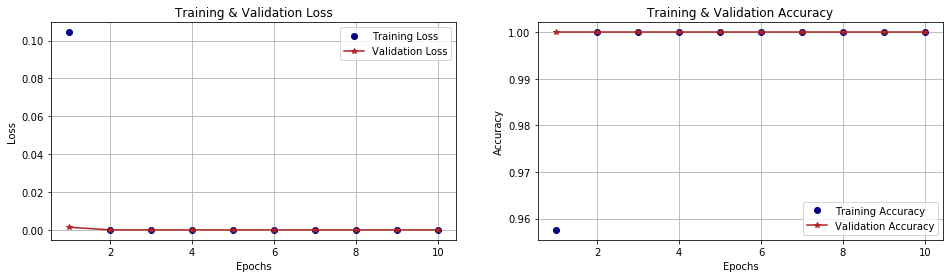

In [14]:
show_plots(history.history)


In [15]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

20/20 [==============================] - 1s 35ms/step - loss: 3.3570e-08 - accuracy: 1.0000
Test loss: 0.0000 accuracy: 1.0000


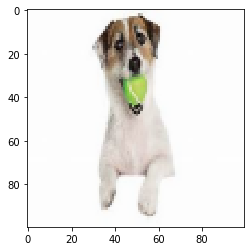

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
actual: cat
predicted: cat


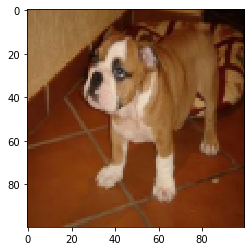

actual: cat
predicted: cat


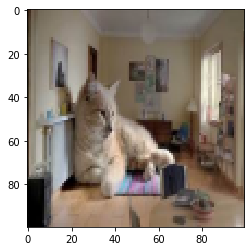

actual: cat
predicted: cat


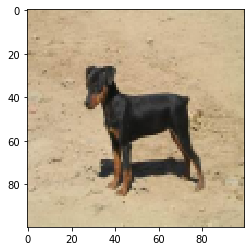

actual: cat
predicted: cat


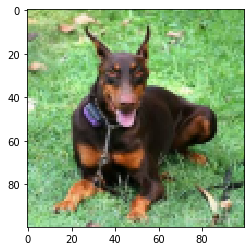

actual: cat
predicted: cat


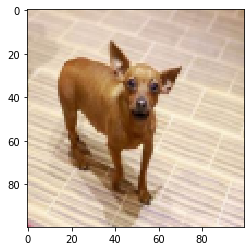

actual: cat
predicted: cat


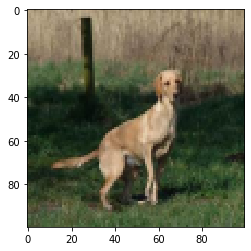

actual: cat
predicted: cat


In [16]:
im_list = [29,31,58,73,44,85,899]
for a in im_list:
#     i = 1000  #index from test data to be used, change this other value to see a different image
    img = test_data[a]
    plt.imshow(img)
    plt.show()
    pred = model.predict_classes(img.reshape(-1,100,100,3))
    actual =  test_labels[a]
    print(f'actual: {get_commonname(actual)}')
    print(f'predicted: {get_commonname(pred)}')

In [17]:
# save model
model.save("cat_dog.h5")

In [1]:
!jupyter nbconvert -- to script animal_dataset.ipynb


[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'script' matched no files
[NbConvertApp] Converting notebook animal_dataset.ipynb to html
[NbConvertApp] Writing 723352 bytes to animal_dataset.html
